# Model Development

Now we are goin to contrast 4 models:

- XGboost
- Logistic Regression
- Catboost
- LightGBM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
import shap
import joblib

# Project utilities (expected in repo)
from functions import (
    DataProfile,
    FeatureEngineering,
    StabilityMetrics,
    WOEAnalysis,
    ModelEvaluation,
    BusinessAnalysis,
)

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Data Loading and preprocessing

In [2]:
X_train = pd.read_parquet("data/eda/X_train.parquet")
X_valid = pd.read_parquet("data/eda/X_valid.parquet")
X_test = pd.read_parquet("data/eda/X_test.parquet")

y_train = np.load("data/eda/y_train.npy")
y_valid = np.load("data/eda/y_valid.npy")
y_test = np.load("data/eda/y_test.npy")

print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")
print(f"Test:  {X_test.shape}")
print(f"\nDefault rates:")
print(f"Train: {y_train.mean():.2%}")
print(f"Valid: {y_valid.mean():.2%}")
print(f"Test:  {y_test.mean():.2%}")

Train: (845679, 30)
Valid: (225005, 30)
Test:  (237923, 30)

Default rates:
Train: 17.19%
Valid: 12.05%
Test:  8.45%


In [3]:
FINAL_FEATURE_SET = ['acc_open_past_24mths',
 'all_util',
 'avg_cur_bal_bin',
 'bc_open_to_buy',
 'dti',
 'emp_length_yrs',
 'fico_mid',
 'home_ownership',
 'il_util',
 'inq_fi',
 'inq_last_12m_bin',
 'inq_last_6mths_bin',
 'install_to_income_bin',
 'loan_to_income_bin',
 'max_bal_bc',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_rcnt_il',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_actv_rev_tl',
 'num_tl_op_past_12m',
 'open_acc_6m',
 'open_il_24m',
 'open_rv_12m',
 'open_rv_24m',
 'total_bc_limit',
 'verification_status']

In [4]:
cat_features = [
    "home_ownership",
    "inq_last_6mths_bin",
    "install_to_income_bin",
    "loan_to_income_bin",
    "verification_status",
    "avg_cur_bal_bin",
    "inq_last_12m_bin",
]
cat_features = [f for f in cat_features if f in FINAL_FEATURE_SET]
num_features = [f for f in FINAL_FEATURE_SET if f not in cat_features]

print(f"Categorical features ({len(cat_features)}): {cat_features}")
print(f"Numeric features ({len(num_features)}): {len(num_features)}")

numeric_transformer = SimpleImputer(strategy="median")
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ],
    remainder="drop",
)

preprocessor.fit(X_train)
X_train_prep = preprocessor.transform(X_train)
X_valid_prep = preprocessor.transform(X_valid)
X_test_prep = preprocessor.transform(X_test)

feature_names = num_features.copy()
if cat_features:
    ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    feature_names += list(ohe.get_feature_names_out(cat_features))

print(f"\nTotal features after preprocessing: {len(feature_names)}")

Categorical features (7): ['home_ownership', 'inq_last_6mths_bin', 'install_to_income_bin', 'loan_to_income_bin', 'verification_status', 'avg_cur_bal_bin', 'inq_last_12m_bin']
Numeric features (23): 23

Total features after preprocessing: 56


### 5.1 XGBoost Model

In [5]:
n_positive = (y_train == 1).sum()
n_negative = (y_train == 0).sum()
scale_pos_weight = n_negative / n_positive

print(f"Class imbalance ratio: {scale_pos_weight:.2f}")

monotone_constraints = {
    "dti": +1,
    "percent_bc_gt_75": +1,
    "num_tl_op_past_12m": +1,
    "open_rv_12m": +1,
    "open_rv_24m": +1,
    "fico_mid": -1,
    "bc_open_to_buy": -1,
    "avg_cur_bal": -1,
    "total_bc_limit": -1,
    "mths_since_recent_inq": -1,
    "mths_since_rcnt_il": -1,
    "mths_since_recent_bc": -1,
}

mono_vec = [monotone_constraints.get(f, 0) for f in num_features]
mono_vec += [0] * (len(feature_names) - len(num_features))
monotone_str = "(" + ",".join(str(int(v)) for v in mono_vec) + ")"

xgb_params = {
    "eta": 0.03,
    "max_depth": 4,
    "min_child_weight": 20,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "alpha": 5.0,
    "lambda": 10.0,
    "tree_method": "hist",
    "objective": "binary:logistic",
    "scale_pos_weight": scale_pos_weight,
    "eval_metric": ["auc", "aucpr", "logloss"],
    "monotone_constraints": monotone_str,
    "random_state": RANDOM_STATE,
}

dtrain = xgb.DMatrix(X_train_prep, label=y_train, feature_names=feature_names)
dvalid = xgb.DMatrix(X_valid_prep, label=y_valid, feature_names=feature_names)
dtest = xgb.DMatrix(X_test_prep, label=y_test, feature_names=feature_names)

print("\nTraining XGBoost model...")
evals = [(dtrain, "train"), (dvalid, "valid")]
xgb_model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=5000,
    evals=evals,
    early_stopping_rounds=200,
    verbose_eval=100,
)

print(f"\nBest iteration: {xgb_model.best_iteration}")

Class imbalance ratio: 4.82

Training XGBoost model...
[0]	train-auc:0.62683	train-aucpr:0.25332	train-logloss:0.69162	valid-auc:0.61897	valid-aucpr:0.17645	valid-logloss:0.69127
[100]	train-auc:0.67474	train-aucpr:0.29297	train-logloss:0.64817	valid-auc:0.66797	valid-aucpr:0.20577	valid-logloss:0.62998
[200]	train-auc:0.68070	train-aucpr:0.29906	train-logloss:0.64179	valid-auc:0.67311	valid-aucpr:0.20997	valid-logloss:0.62354
[300]	train-auc:0.68360	train-aucpr:0.30201	train-logloss:0.63958	valid-auc:0.67566	valid-aucpr:0.21204	valid-logloss:0.62171
[400]	train-auc:0.68546	train-aucpr:0.30393	train-logloss:0.63858	valid-auc:0.67706	valid-aucpr:0.21322	valid-logloss:0.62150
[500]	train-auc:0.68687	train-aucpr:0.30545	train-logloss:0.63766	valid-auc:0.67791	valid-aucpr:0.21394	valid-logloss:0.62121
[600]	train-auc:0.68800	train-aucpr:0.30674	train-logloss:0.63712	valid-auc:0.67846	valid-aucpr:0.21453	valid-logloss:0.62122
[700]	train-auc:0.68892	train-aucpr:0.30781	train-logloss:0.63646

In [6]:
y_train_pred_raw = xgb_model.predict(dtrain, iteration_range=(0, xgb_model.best_iteration + 1))
y_valid_pred_raw = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
y_test_pred_raw = xgb_model.predict(dtest, iteration_range=(0, xgb_model.best_iteration + 1))

print("Calibrating predictions...")
calibrator = IsotonicRegression(out_of_bounds="clip")
calibrator.fit(y_valid_pred_raw, y_valid)

y_train_pred_xgb = calibrator.predict(y_train_pred_raw)
y_valid_pred_xgb = calibrator.predict(y_valid_pred_raw)
y_test_pred_xgb = calibrator.predict(y_test_pred_raw)

Calibrating predictions...


### 5.2 LightGBM Model

In [7]:
print("\nTraining LightGBM model...")

lgb_params = {
    "objective": "binary",
    "metric": ["auc", "binary_logloss"],
    "boosting_type": "gbdt",
    "learning_rate": 0.03,
    "num_leaves": 31,
    "max_depth": 4,
    "min_child_samples": 20,
    "subsample": 0.8,
    "subsample_freq": 1,
    "colsample_bytree": 0.8,
    "reg_alpha": 5.0,
    "reg_lambda": 10.0,
    "scale_pos_weight": scale_pos_weight,
    "verbose": -1,
    "random_state": RANDOM_STATE,
}

lgb_train = lgb.Dataset(
    X_train_prep, label=y_train, feature_name=feature_names, categorical_feature="auto"
)
lgb_valid = lgb.Dataset(
    X_valid_prep, label=y_valid, feature_name=feature_names, categorical_feature="auto", reference=lgb_train
)

lgb_model = lgb.train(
    params=lgb_params,
    train_set=lgb_train,
    num_boost_round=5000,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=["train", "valid"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=200, verbose=True),
        lgb.log_evaluation(period=100),
    ],
)

print(f"\nBest iteration: {lgb_model.best_iteration}")

y_train_pred_lgb_raw = lgb_model.predict(X_train_prep, num_iteration=lgb_model.best_iteration)
y_valid_pred_lgb_raw = lgb_model.predict(X_valid_prep, num_iteration=lgb_model.best_iteration)
y_test_pred_lgb_raw = lgb_model.predict(X_test_prep, num_iteration=lgb_model.best_iteration)

print("Calibrating LightGBM predictions...")
calibrator_lgb = IsotonicRegression(out_of_bounds="clip")
calibrator_lgb.fit(y_valid_pred_lgb_raw, y_valid)

y_train_pred_lgb = calibrator_lgb.predict(y_train_pred_lgb_raw)
y_valid_pred_lgb = calibrator_lgb.predict(y_valid_pred_lgb_raw)
y_test_pred_lgb = calibrator_lgb.predict(y_test_pred_lgb_raw)


Training LightGBM model...
Training until validation scores don't improve for 200 rounds
[100]	train's auc: 0.67644	train's binary_logloss: 0.627619	valid's auc: 0.669347	valid's binary_logloss: 0.608064
[200]	train's auc: 0.682336	train's binary_logloss: 0.640402	valid's auc: 0.674674	valid's binary_logloss: 0.622897
Early stopping, best iteration is:
[1]	train's auc: 0.628735	train's binary_logloss: 0.457561	valid's auc: 0.626139	valid's binary_logloss: 0.380382

Best iteration: 1
Calibrating LightGBM predictions...


### 5.3 CatBoost Model

In [8]:
print("\nTraining CatBoost model...")

cat_feature_indices = [FINAL_FEATURE_SET.index(f) for f in cat_features if f in FINAL_FEATURE_SET]

cat_train = Pool(data=X_train[FINAL_FEATURE_SET], label=y_train, cat_features=cat_feature_indices)
cat_valid = Pool(data=X_valid[FINAL_FEATURE_SET], label=y_valid, cat_features=cat_feature_indices)
cat_test = Pool(data=X_test[FINAL_FEATURE_SET], label=y_test, cat_features=cat_feature_indices)

catboost_params = {
    "iterations": 5000,
    "learning_rate": 0.03,
    "depth": 4,
    "l2_leaf_reg": 10.0,
    "min_data_in_leaf": 20,
    "subsample": 0.8,
    "random_strength": 1.0,
    "bagging_temperature": 1.0,
    "scale_pos_weight": scale_pos_weight,
    "eval_metric": "AUC",
    "random_seed": RANDOM_STATE,
    "verbose": 100,
    "early_stopping_rounds": 200,
    "task_type": "CPU",
    "use_best_model": True,
}

cat_model = CatBoostClassifier(**catboost_params)
cat_model.fit(cat_train, eval_set=cat_valid, verbose=100, plot=False)

print(f"\nBest iteration: {cat_model.get_best_iteration()}")

y_train_pred_cat_raw = cat_model.predict_proba(cat_train)[:, 1]
y_valid_pred_cat_raw = cat_model.predict_proba(cat_valid)[:, 1]
y_test_pred_cat_raw = cat_model.predict_proba(cat_test)[:, 1]

print("Calibrating CatBoost predictions...")
calibrator_cat = IsotonicRegression(out_of_bounds="clip")
calibrator_cat.fit(y_valid_pred_cat_raw, y_valid)

y_train_pred_cat = calibrator_cat.predict(y_train_pred_cat_raw)
y_valid_pred_cat = calibrator_cat.predict(y_valid_pred_cat_raw)
y_test_pred_cat = calibrator_cat.predict(y_test_pred_cat_raw)


Training CatBoost model...
0:	test: 0.6249553	best: 0.6249553 (0)	total: 212ms	remaining: 17m 41s
100:	test: 0.6656525	best: 0.6656525 (100)	total: 13.9s	remaining: 11m 12s
200:	test: 0.6705558	best: 0.6705558 (200)	total: 28.1s	remaining: 11m 10s
300:	test: 0.6735017	best: 0.6735017 (300)	total: 42.7s	remaining: 11m 6s
400:	test: 0.6752929	best: 0.6752929 (400)	total: 57.5s	remaining: 10m 59s
500:	test: 0.6767220	best: 0.6767220 (500)	total: 1m 12s	remaining: 10m 53s
600:	test: 0.6777618	best: 0.6777618 (600)	total: 1m 28s	remaining: 10m 44s
700:	test: 0.6785966	best: 0.6785966 (700)	total: 1m 43s	remaining: 10m 31s
800:	test: 0.6792934	best: 0.6792968 (799)	total: 1m 58s	remaining: 10m 20s
900:	test: 0.6797600	best: 0.6797600 (900)	total: 2m 13s	remaining: 10m 6s
1000:	test: 0.6802088	best: 0.6802088 (1000)	total: 2m 28s	remaining: 9m 53s
1100:	test: 0.6806272	best: 0.6806272 (1100)	total: 2m 44s	remaining: 9m 42s
1200:	test: 0.6809459	best: 0.6809471 (1198)	total: 2m 59s	remaining:

### 5.4 Logistic Regression

In [9]:
print("Training Logistic Regression...")

lr_model = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=5000,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

lr_model.fit(X_train_prep, y_train)

y_train_pred_lr_raw = lr_model.predict_proba(X_train_prep)[:, 1]
y_valid_pred_lr_raw = lr_model.predict_proba(X_valid_prep)[:, 1]
y_test_pred_lr_raw = lr_model.predict_proba(X_test_prep)[:, 1]

calibrator_lr = IsotonicRegression(out_of_bounds="clip")
calibrator_lr.fit(y_valid_pred_lr_raw, y_valid)

y_train_pred_lr = calibrator_lr.predict(y_train_pred_lr_raw)
y_valid_pred_lr = calibrator_lr.predict(y_valid_pred_lr_raw)
y_test_pred_lr = calibrator_lr.predict(y_test_pred_lr_raw)

Training Logistic Regression...


## 6. Model Evaluation & Interpretation

# 6.1 Comparison by Main Metrics (K-S, AUC)

In [10]:
evaluator = ModelEvaluation()
stability = StabilityMetrics()

# XGBoost evaluation
xgb_metrics = {}
xgb_metrics.update(evaluator.comprehensive_metrics(y_train, y_train_pred_xgb, "Train"))
xgb_metrics.update(evaluator.comprehensive_metrics(y_valid, y_valid_pred_xgb, "Valid"))
xgb_metrics.update(evaluator.comprehensive_metrics(y_test, y_test_pred_xgb, "Test"))

xgb_results = pd.DataFrame([xgb_metrics]).T
xgb_results.columns = ["XGBoost"]

# LightGBM evaluation
lgb_metrics = {}
lgb_metrics.update(evaluator.comprehensive_metrics(y_train, y_train_pred_lgb, "Train"))
lgb_metrics.update(evaluator.comprehensive_metrics(y_valid, y_valid_pred_lgb, "Valid"))
lgb_metrics.update(evaluator.comprehensive_metrics(y_test, y_test_pred_lgb, "Test"))

lgb_results = pd.DataFrame([lgb_metrics]).T
lgb_results.columns = ["LightGBM"]

# CatBoost evaluation
cat_metrics = {}
cat_metrics.update(evaluator.comprehensive_metrics(y_train, y_train_pred_cat, "Train"))
cat_metrics.update(evaluator.comprehensive_metrics(y_valid, y_valid_pred_cat, "Valid"))
cat_metrics.update(evaluator.comprehensive_metrics(y_test, y_test_pred_cat, "Test"))

cat_results = pd.DataFrame([cat_metrics]).T
cat_results.columns = ["CatBoost"]

# Logistic Regression evaluation
lr_metrics = {}
lr_metrics.update(evaluator.comprehensive_metrics(y_train, y_train_pred_lr, "Train"))
lr_metrics.update(evaluator.comprehensive_metrics(y_valid, y_valid_pred_lr, "Valid"))
lr_metrics.update(evaluator.comprehensive_metrics(y_test, y_test_pred_lr, "Test"))

lr_results = pd.DataFrame([lr_metrics]).T
lr_results.columns = ["Logistic Regression"]

In [11]:
comparison = pd.concat([xgb_results, lgb_results, cat_results, lr_results], axis=1)
print("\n" + "=" * 50)
print("Model Comparison")
print("=" * 50)
display(comparison)


Model Comparison


,XGBoost,LightGBM,CatBoost,Logistic Regression
AUC_Train,0.689597,0.628664,0.697607,0.648740
PR_AUC_Train,0.303030,0.241209,0.313294,0.262562
KS_Train,0.273401,0.189679,0.284045,0.214366
AUC_Valid,0.679668,0.626410,0.683969,0.640040
PR_AUC_Valid,0.212307,0.172579,0.218495,0.182932
KS_Valid,0.259242,0.188126,0.264984,0.202342
AUC_Test,0.669427,0.611028,0.673809,0.630030
PR_AUC_Test,0.148268,0.117981,0.152799,0.127334
KS_Test,0.244318,0.159240,0.251764,0.190442


### 6.2 K-S Curve Analysis

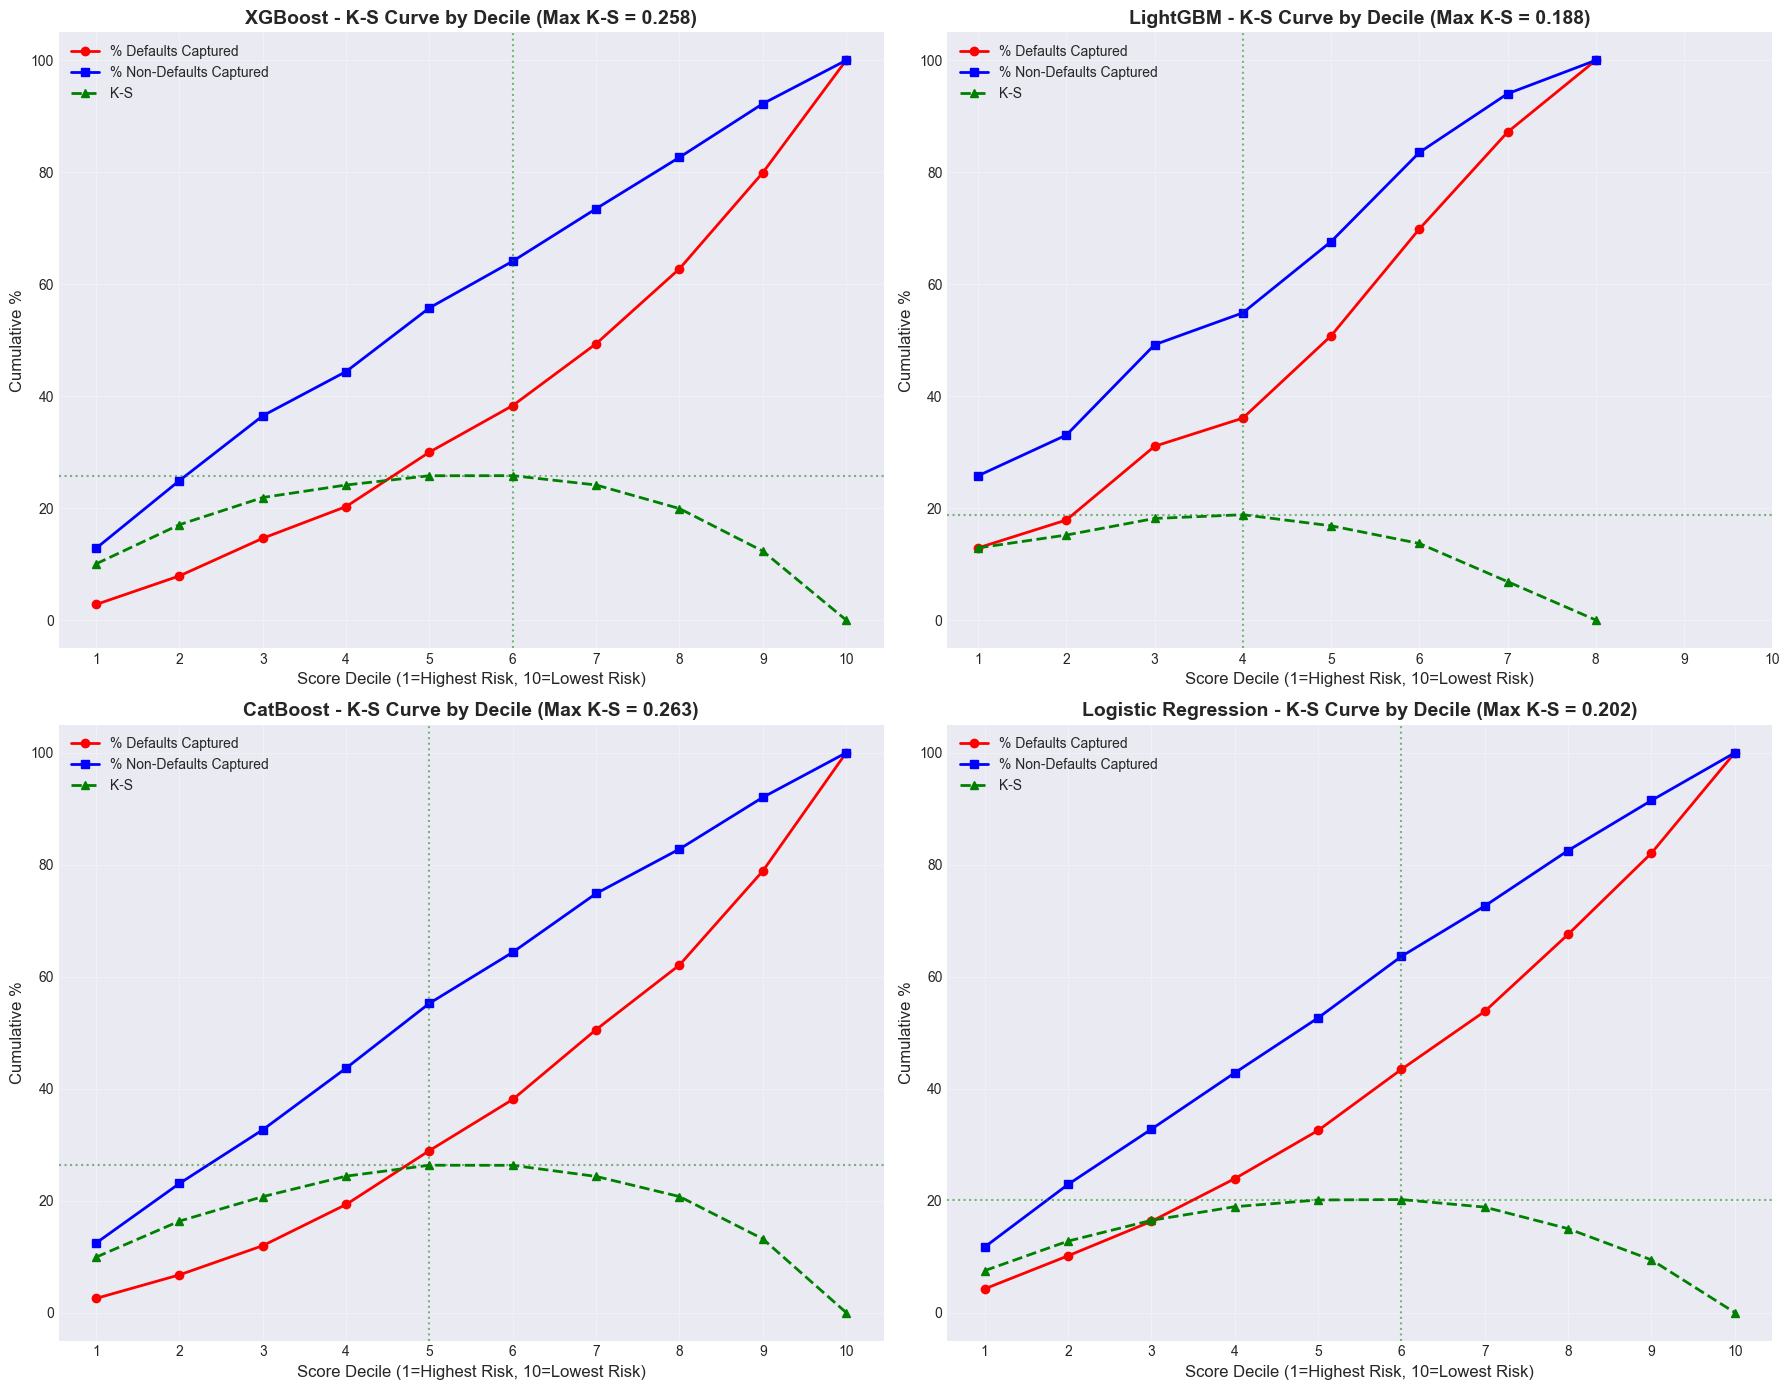


K-S Statistics Summary (Validation Set):


,Model,K-S Statistic,K-S Score,TPR at K-S,FPR at K-S,Capture Rate (TPR - FPR)
2,CatBoost,0.2632,5.0000,0.0000,0.0000,0.0000
0,XGBoost,0.2579,6.0000,0.0000,0.0000,0.0000
3,Logistic Regression,0.2018,6.0000,0.0000,0.0000,0.0000
1,LightGBM,0.1881,4.0000,0.0000,0.0000,0.0000


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

models_ks = [
    ("XGBoost", y_valid_pred_xgb),
    ("LightGBM", y_valid_pred_lgb),
    ("CatBoost", y_valid_pred_cat),
    ("Logistic Regression", y_valid_pred_lr),
]

ks_results = []

for idx, (model_name, y_pred) in enumerate(models_ks):
    ks_stat, ks_score = evaluator.plot_ks_curve_deciles(y_valid, y_pred, model_name, ax=axes[idx])
    
    binary_pred = (y_pred >= ks_score).astype(int)
    
    # Calculate confusion matrix values
    tp = np.sum((binary_pred == 1) & (y_valid == 1))
    fp = np.sum((binary_pred == 1) & (y_valid == 0))
    tn = np.sum((binary_pred == 0) & (y_valid == 0))
    fn = np.sum((binary_pred == 0) & (y_valid == 1))
    
    # Calculate TPR and FPR
    tpr_at_ks = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr_at_ks = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    ks_results.append({
        "Model": model_name,
        "K-S Statistic": ks_stat,
        "K-S Score": ks_score,
        "TPR at K-S": tpr_at_ks,
        "FPR at K-S": fpr_at_ks,
    })

plt.tight_layout()
plt.show()

# Create summary table
ks_summary = pd.DataFrame(ks_results)
ks_summary["Capture Rate (TPR - FPR)"] = ks_summary["TPR at K-S"] - ks_summary["FPR at K-S"]
ks_summary = ks_summary.sort_values("K-S Statistic", ascending=False)

print("\nK-S Statistics Summary (Validation Set):")
print("=" * 60)
display(ks_summary.style.format({
    "K-S Statistic": "{:.4f}",
    "K-S Score": "{:.4f}",
    "TPR at K-S": "{:.4f}",
    "FPR at K-S": "{:.4f}",
    "Capture Rate (TPR - FPR)": "{:.4f}",
}).background_gradient(subset=["K-S Statistic"], cmap="RdYlGn"))

### 6.3 ROC Curves Comparison

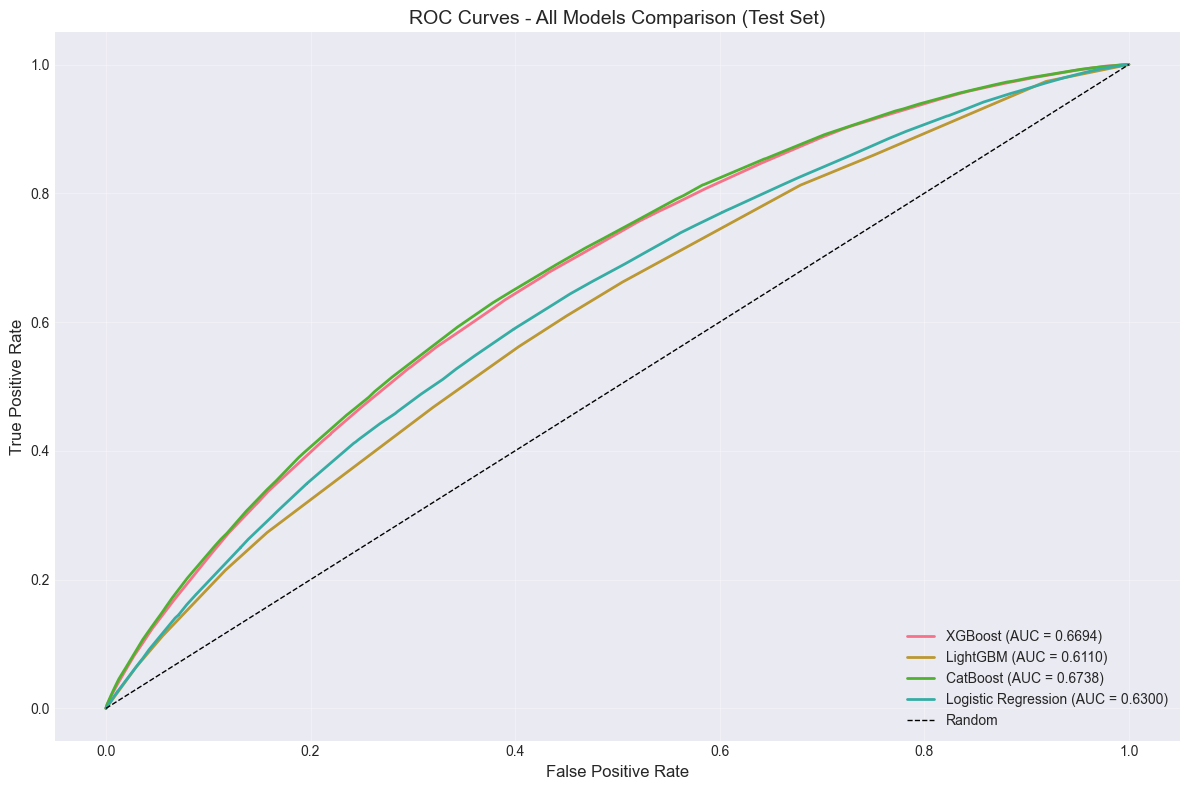

In [13]:
plt.figure(figsize=(12, 8))

models_to_plot = [
    ("XGBoost", y_test_pred_xgb),
    ("LightGBM", y_test_pred_lgb),
    ("CatBoost", y_test_pred_cat),
    ("Logistic Regression", y_test_pred_lr),
]

for name, y_pred in models_to_plot:
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, linewidth=2, label=f"{name} (AUC = {auc_score:.4f})")

plt.plot([0, 1], [0, 1], "k--", linewidth=1, label="Random")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curves - All Models Comparison (Test Set)", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 6.4 Shap Analysis

In [14]:
N_SAMPLE = min(5000, X_valid_prep.shape[0])
sample_idx = np.random.choice(X_valid_prep.shape[0], N_SAMPLE, replace=False)
X_shap = X_valid_prep[sample_idx]

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_shap)

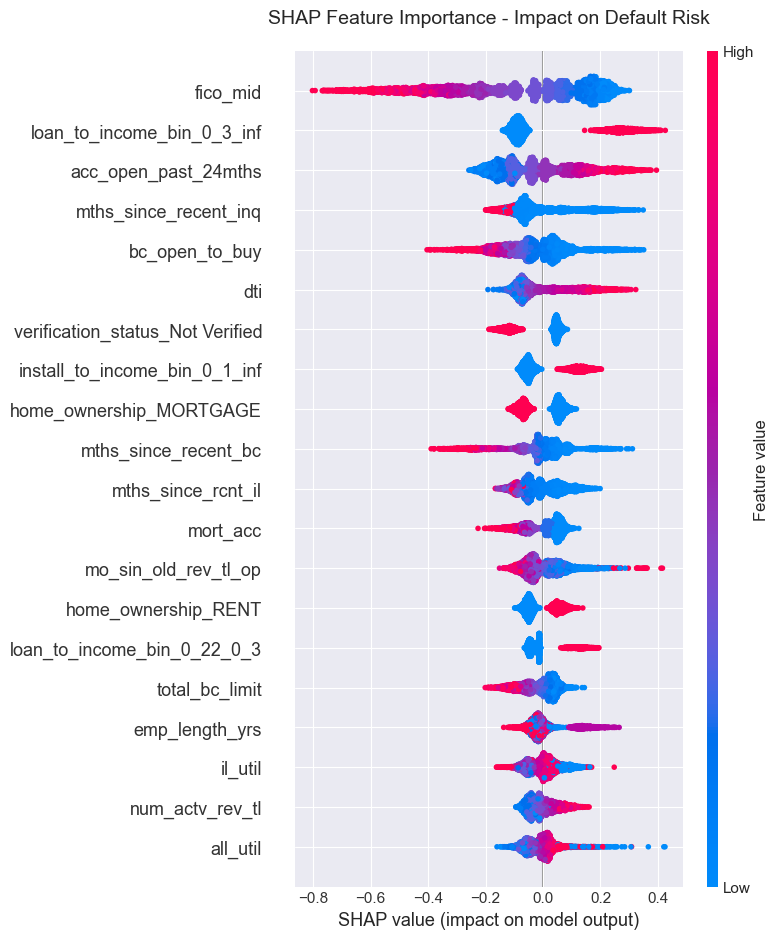

In [15]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_shap, feature_names=feature_names, show=False, max_display=20)
plt.title("SHAP Feature Importance - Impact on Default Risk", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

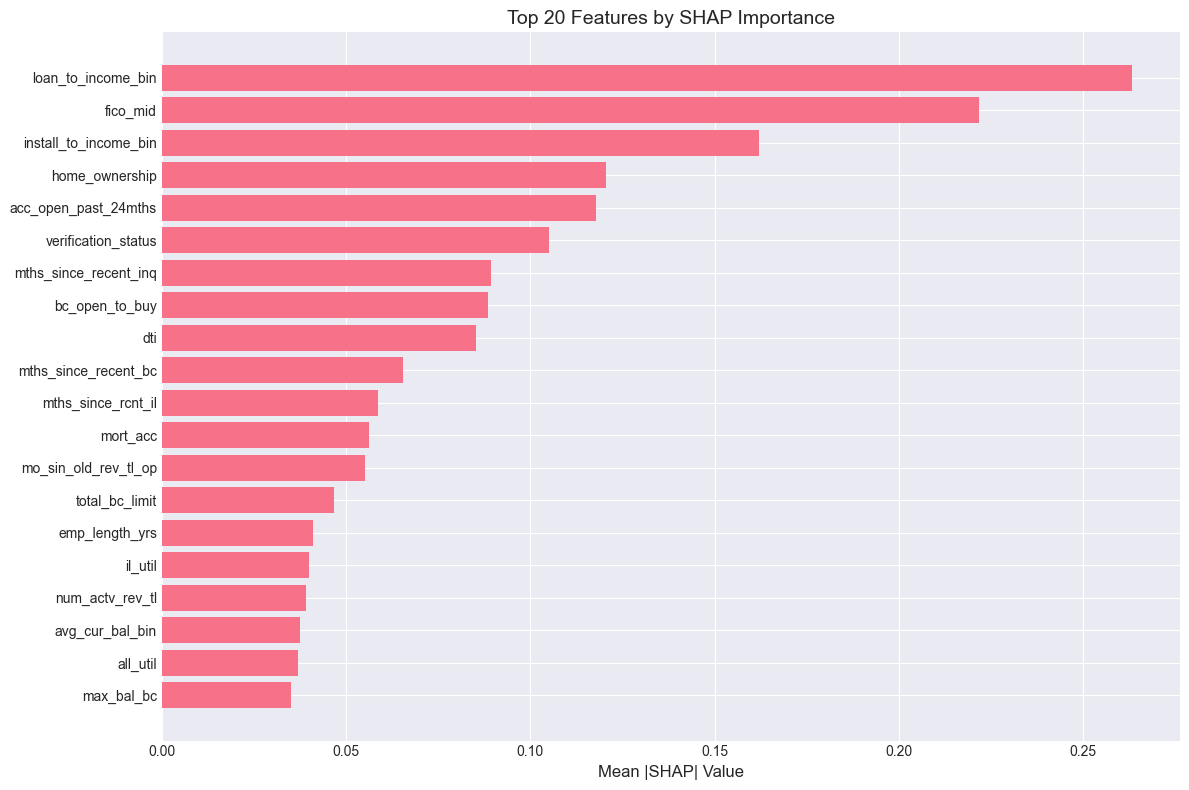


Top 10 Most Important Features:


,feature,mean_abs_shap
13,loan_to_income_bin,0.263195
6,fico_mid,0.221818
12,install_to_income_bin,0.162200
7,home_ownership,0.120533
0,acc_open_past_24mths,0.117877
29,verification_status,0.105019
21,mths_since_recent_inq,0.089217
3,bc_open_to_buy,0.088474
4,dti,0.085368
20,mths_since_recent_bc,0.065469


In [16]:
cat_feature_set = set(cat_features)

def get_original_feature(col_name: str) -> str:
    for cat_feat in cat_feature_set:
        if col_name.startswith(f"{cat_feat}_"):
            return cat_feat
    return col_name

original_names = [get_original_feature(f) for f in feature_names]
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)

shap_importance = (
    pd.DataFrame({"feature": original_names, "mean_abs_shap": mean_abs_shap})
    .groupby("feature", as_index=False)["mean_abs_shap"]
    .sum()
    .sort_values("mean_abs_shap", ascending=False)
)

plt.figure(figsize=(12, 8))
plt.barh(shap_importance["feature"].iloc[:20][::-1], shap_importance["mean_abs_shap"].iloc[:20][::-1])
plt.xlabel("Mean |SHAP| Value", fontsize=12)
plt.title("Top 20 Features by SHAP Importance", fontsize=14)
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
display(shap_importance.head(10))

In [17]:
from sklearn.metrics import precision_score, recall_score

thresh = 0.10
preds = {
    "XGBoost": y_valid_pred_xgb,
    "LightGBM": y_valid_pred_lgb,
    "CatBoost": y_valid_pred_cat,
    "Logistic": y_valid_pred_lr,
}

rows = []
for name, y_score in preds.items():
    y_hat = (y_score >= thresh).astype(int)
    rows.append({
        "model": name,
        "precision": precision_score(y_valid, y_hat, zero_division=0),
        "recall": recall_score(y_valid, y_hat, zero_division=0),
    })

prec_rec_table = pd.DataFrame(rows).set_index("model").round(4)
display(prec_rec_table)

,precision,recall
model,,
XGBoost,0.1657,0.7877
LightGBM,0.1439,0.8213
CatBoost,0.1690,0.7762
Logistic,0.1558,0.7471


# 7. Business Analysis

Based on the K-S statistics, AUC and  precision/recall metrics we select the Catboost model for further business analysis. Next we analize which could be the best threshold based on expected defaulters

In [18]:
display(evaluator.decile_ks_analysis(y_valid, y_valid_pred_cat, "CatBoost"))


CatBoost - Scorecard Analysis
K-S:   26.32%
AR:    68.40%
GINI:  36.79%



,"('Segment', 'Variable')","('All', 'Total')","('All', '%INT')","('All', '%AC')","('Goods', 'Total')","('Goods', '%INT')","('Goods', '%AC')","('Bads', 'Total')","('Bads', '%INT')","('Bads', '%AC')","('Metrics', 'ODDS')","('Metrics', 'K-S')"
0,0.00%-4.12%,25269,11.23%,11.23%,24584,12.42%,12.42%,685,2.53%,2.53%,35.89,9.90%
1,4.23%-6.34%,22199,9.87%,21.10%,21059,10.64%,23.06%,1140,4.20%,6.73%,18.47,16.33%
2,6.59%-7.20%,20393,9.06%,30.16%,18979,9.59%,32.66%,1414,5.22%,11.95%,13.42,20.71%
3,7.68%-8.91%,23794,10.57%,40.73%,21799,11.02%,43.67%,1995,7.36%,19.30%,10.93,24.37%
4,9.07%-11.02%,25536,11.35%,52.08%,22924,11.58%,55.25%,2612,9.63%,28.94%,8.78,26.32%
5,11.11%-12.54%,20523,9.12%,61.20%,18045,9.12%,64.37%,2478,9.14%,38.08%,7.28,26.30%
6,12.92%-15.36%,24147,10.73%,71.94%,20765,10.49%,74.87%,3382,12.47%,50.55%,6.14,24.32%
7,15.38%-17.51%,18836,8.37%,80.31%,15709,7.94%,82.80%,3127,11.53%,62.08%,5.02,20.72%
8,18.07%-22.36%,22837,10.15%,90.46%,18282,9.24%,92.04%,4555,16.80%,78.88%,4.01,13.16%
9,22.69%-100.00%,21471,9.54%,100.00%,15746,7.96%,100.00%,5725,21.12%,100.00%,2.75,0.00%


In [19]:
business = BusinessAnalysis()

threshold_analysis = business.analyze_thresholds(y_valid, y_valid_pred_cat)

print("Threshold Analysis (Test Set):")
display(
    threshold_analysis[
        ["threshold", "approval_rate", "default_rate_approved", "approved_defaults", "expected_loss"]
    ].head(15)
)

Threshold Analysis (Test Set):


,threshold,approval_rate,default_rate_approved,approved_defaults,expected_loss
0,0.05,0.163739,0.033114,1220,14640000.0
1,0.10,0.446479,0.060402,6068,72816000.0
2,0.15,0.693309,0.082097,12807,153684000.0
3,0.20,0.860465,0.099474,19259,231108000.0
4,0.25,0.946975,0.111022,23656,283872000.0
5,0.30,0.979067,0.115827,25516,306192000.0
6,0.35,0.997689,0.119714,26874,322488000.0
7,0.40,0.997689,0.119714,26874,322488000.0
8,0.45,0.999129,0.120169,27015,324180000.0
9,0.50,0.999920,0.120451,27100,325200000.0


## 8. Save Model Artifacts

In [27]:
output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)

xgb_model.save_model(str(output_dir / "xgboost_model.json"))
lgb_model.save_model(str(output_dir / "lightgbm_model.txt"))
cat_model.save_model(str(output_dir / "catboost_model.cbm"))

joblib.dump(preprocessor, output_dir / "preprocessor.pkl")
joblib.dump(calibrator, output_dir / "calibrator_xgb.pkl")
joblib.dump(calibrator_lgb, output_dir / "calibrator_lgb.pkl")
joblib.dump(calibrator_cat, output_dir / "calibrator_cat.pkl")
joblib.dump(lr_model, output_dir / "logistic_regression.pkl")
joblib.dump(calibrator_lr, output_dir / "calibrator_lr.pkl")

with open(output_dir / "feature_list.txt", "w") as f:
    f.write("\n".join(FINAL_FEATURE_SET))

threshold_analysis.to_csv(output_dir / "threshold_analysis.csv", index=False)
shap_importance.to_csv(output_dir / "shap_importance.csv", index=False)
ks_summary.to_csv(output_dir / "ks_analysis_validation.csv", index=False)

np.save(output_dir / "predictions.npy", y_valid_pred_cat) 
np.save(output_dir / "predictions_test.npy", y_test_pred_cat) 

print("\nModel artifacts saved to outputs/:")
print("  - xgboost_model.json")
print("  - lightgbm_model.txt")
print("  - catboost_model.cbm")
print("  - logistic_regression.pkl")
print("  - preprocessor.pkl")
print("  - calibrator_xgb.pkl")
print("  - calibrator_lgb.pkl")
print("  - calibrator_cat.pkl")
print("  - calibrator_lr.pkl")
print("  - feature_list.txt")
print("  - threshold_analysis.csv")
print("  - segment_analysis.csv")
print("  - shap_importance.csv")
print("  - ks_analysis_validation.csv")


Model artifacts saved to outputs/:
  - xgboost_model.json
  - lightgbm_model.txt
  - catboost_model.cbm
  - logistic_regression.pkl
  - preprocessor.pkl
  - calibrator_xgb.pkl
  - calibrator_lgb.pkl
  - calibrator_cat.pkl
  - calibrator_lr.pkl
  - feature_list.txt
  - threshold_analysis.csv
  - segment_analysis.csv
  - shap_importance.csv
  - ks_analysis_validation.csv
